# 20191024 - Accounting for source of NMD targets

In [1]:
import pandas as pd
import numpy as np
import math

def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

Import Colombo et al. NMD targets (my own computations)

In [2]:
import pandas as pd
import pandas as pd

colombo_p_values = pd.read_csv('5.042_20191002_colombo_meta_pvalues.tsv', sep = '\t', usecols=range(15)[1:])
colombo_p_values.sort_values(by=['meta_meta'], inplace=True)

## add annotations for presence of downstream EJC, length of 3'UTR, uORFS, etc

In [3]:
#add NMD annotations from GENCODE
import gzip
from collections import defaultdict

def revComp(seq, isRNA = False):
    seq = seq.upper()
    compDict = {'A':'T', 'T':'A', 'U':'A', 'C':'G', 'G':'C', 'N':'N', '-':'-', '.':'.', '*':'*'}
    revComp = ''.join([compDict[c] for c in seq[::-1]])
    if isRNA:
        return revComp.replace('T', 'U')
    return revComp

class genome_sequence():
    def __init__(self, fasta_file, *args):
        self.genome_sequence = self.convertFastaToDict(fasta_file, *args)
    
    def get_references(self):
        '''
        return chromosome names
        '''
        return sorted(self.genome_sequence.keys())
    
    def get_sequence(self, chromosome, start, end, strand):
        """
        returns a string of genome sequence at the given start and end positions, inclusive
        reverse-complemented for minus strand
        
        start and end are 1-indexed (first base-pair of genome is 1)
        """
        assert end >= start
        sequence = self.genome_sequence[chromosome][start-1: end]
        if strand == '-':
            return revComp(sequence)
        else:
            return sequence     

    def convertFastaToDict(self, fastaFile, *args):
        '''
        converts a fasta file to a dict of {sequenceName:sequence}
        can take extra files in * args
        '''
        files = [fastaFile]
        for extra_file in args:
            files.append(extra_file)
        currentName = None
        currentSequence = None
        seqDict = {}
        for currentFile in files:
            if currentFile.endswith('.gz'):
                f = gzip.open(currentFile)
            else:
                f = open(currentFile)
            for line in f:
                if not line.strip() == '' and not line.startswith('#'):#ignore empty lines and commented out lines
                    if line.startswith('>'):#> marks the start of a new sequence
                        if not currentName == None: #after we've reached the firtst > line, we know what the sequence corresponds to
                            seqDict[currentName] = currentSequence
                        currentName = line.strip()[1:].split()[0] #i've noticed the gencode names have extraneous numbering after some whitespace. This doens't match the GTF files, so I'm removing it.
                        currentSequence = ''
                    else:
                        currentSequence += line.strip()
            f.close()
        seqDict[currentName] = currentSequence
        return seqDict

    def write_genome_sequence_to_FASTA(self, fasta_file, chromosomes=None):
        out_file = open(fasta_file, 'w')
        if chromosomes == None:
            chromosomes = self.get_references()
        for chromosome in chromosomes:
            out_file.write('>%s\n' % chromosome)
            out_file.write('%s\n' % self.genome_sequence[chromosome])        
        out_file.close()        


class appris_entry():
    def __init__(self, line):
        self.name, self.ensg, self.enst, self.ccds, self.appris_score = line.strip('\n').split('\t')
    
    def __repr__(self):
        return ' '.join([self.name, self.ensg, self.enst, self.ccds, self.appris_score])
class gtf_data():
    def __init__(self, gtf_file):
        self.gtf_entries = []
        self.transcript_to_entries = defaultdict(set)
        self.gene_to_entries = defaultdict(set)
        self.genes_to_tx = defaultdict(set)
        self.add_gtf_data(gtf_file)
    def add_gtf_data(self, gtf_file):
        if gtf_file.endswith('.gz'):
            gtf = gzip.open(gtf_file)
        else:
            gtf = open(gtf_file)
        for line in gtf:
            if not line.startswith('#'):
                new_entry = gtf_entry(line)
                self.gtf_entries.append(new_entry)
                gene_id = new_entry.get_value('gene_id')
                transcript_id = new_entry.get_value('transcript_id')
                if gene_id != None:
                    self.gene_to_entries[gene_id].add(new_entry)
                    if transcript_id != None:
                        self.transcript_to_entries[transcript_id].add(new_entry)
                        self.genes_to_tx[gene_id].add(transcript_id)
        gtf.close()
    
    def add_appris_data(self, file_name):
        self.appris_data_by_tx = {}
        self.appris_data_by_gene = {}
        self.appris_data_by_ccds = {}
        f = open(file_name)
        for line in f:
            ae = appris_entry(line)
            self.appris_data_by_tx[ae.enst] = ae
            self.appris_data_by_gene[ae.ensg] = ae
            self.appris_data_by_ccds[ae.ccds] = ae
        f.close()
                    
    def print_transcript_multiplicity(self, gene_type=None):
        self.tx_counts_histogram = defaultdict(int)
        for gene_id in self.genes_to_tx:
            if gene_type == None or gene_type == sorted(self.gene_to_entries[gene_id])[0].get_value('gene_type'):
                self.tx_counts_histogram[len(self.genes_to_tx[gene_id])] += 1
        for count in sorted(self.tx_counts_histogram.keys()):
            print count, self.tx_counts_histogram[count]
    
    def spliced_length(self, transcript_id, exon_type='exon'):
        """
        exon_type can be CDS or exon.
        CDS wil start and end at CDS boundaries, so that's convenient
        Returns lenth of transcript or cds
        """
        ordered_exon_entries = self.sorted_exons(transcript_id, exon_type=exon_type)
        if len(ordered_exon_entries) == 0:
            return 0
        transcript_length = sum([exon_entry.length() for exon_entry in ordered_exon_entries])
        return transcript_length
    
    def sorted_exons(self, transcript_id, exon_type='exon'):
        """
        exon_type can be : CDS, exon, UTR, stop_codon, start_codon, or a list containing a combination therof.
        CDS wil start and end at CDS boundaries, but excludes the stop codon. So need to pass ['CDS','stop_codon'] to get the full coding sequence
        -Be careful not to mix annotation types that may overlap, for example exon, with any other, as you will get the wrong sequence, with duplicates.
        Returns exons in annotated order, based on start position of each exon
        Ordering is relative to the sense strand, so the first exon in the list will be the 5'-most exon in the transcript.
        However, the "end" of the exon boundary is always larger than the 'start'
        """
        transcript_entries = self.transcript_to_entries[transcript_id]
        ordered_exon_entries = sorted([entry for entry in transcript_entries if entry.is_type(exon_type)], key=lambda x: int(x.get_value('start')))
        #if this transcript is on the minus strand, the exon order needs to be flipped
        if len(ordered_exon_entries)>0 and ordered_exon_entries[0].get_value('strand') == '-':
            ordered_exon_entries = ordered_exon_entries[::-1]
        return ordered_exon_entries
    
    def transcript_sequence(self, genome_sequence, transcript_id, exon_type='exon'):
        """
        exon_type can be CDS or exon.
        CDS will start and end at CDS boundaries, so that's convenient
        Returns sequence of transcript or cds
        """
        ordered_exon_entries = self.sorted_exons(transcript_id, exon_type=exon_type)
        transcript_sequence = ''.join([exon_entry.sequence(genome_sequence) for exon_entry in ordered_exon_entries])
        return transcript_sequence
    
    def tx_with_longest_CDS(self, gene_id, starting_subset=None):
        """
        starting_subset can be a list of transcript ids. If it is given, then only thos etranscripts will be considered
        """
        if starting_subset==None:
            transcripts = self.genes_to_tx[gene_id]
        else:
            transcripts=starting_subset
        if len(transcripts) == 1:
            return [sorted(transcripts)[0]]
        else:
            sorted_transcripts = sorted(transcripts, key=lambda x: int(self.spliced_length(x, exon_type=['CDS', 'stop_codon'])), reverse=True)
            longest_CDS_length = self.spliced_length(sorted_transcripts[0], exon_type=['CDS', 'stop_codon'])
            return [x for x in sorted_transcripts if self.spliced_length(x, exon_type=['CDS', 'stop_codon']) == longest_CDS_length]

    def longest_tx(self, gene_id, starting_subset=None):
        if starting_subset==None:
            transcripts = self.genes_to_tx[gene_id]
        else:
            transcripts=starting_subset
        if len(transcripts) == 1:
            return [sorted(transcripts)[0]]
        else:
            sorted_transcripts = sorted(transcripts, key=lambda x: int(self.spliced_length(x, exon_type='exon')), reverse=True)
            longest_CDS_length = self.spliced_length(sorted_transcripts[0], exon_type='exon')
            return [x for x in sorted_transcripts if self.spliced_length(x, exon_type='exon') == longest_CDS_length]

    def pick_all_longest_CDS_transcripts(self, key=None, preffered_types=None):
        #picks transcripts with longest CDS
        #If tied picks longest TX
        #Otherwise, pick the first one randomly and make note
        #If there are preffered types (the field flag is defined by "key"), only transcripts of those type will be considered if they exist for that gene
        genes_with_ties = []
        chosen_tx = []
        
        for gene_id in self.genes_to_tx:
            if key is not None and preffered_types is not None:
                all_gene_tx = self.genes_to_tx[gene_id]
                tx_of_preffered_type = self.filter_transcripts_by_value(key, preffered_types, starting_subset=all_gene_tx)
                if len(tx_of_preffered_type) > 0:
                    tx_with_longest_CDS = self.tx_with_longest_CDS(gene_id, starting_subset=tx_of_preffered_type)
                else:
                    tx_with_longest_CDS = self.tx_with_longest_CDS(gene_id)
            else:
                tx_with_longest_CDS = self.tx_with_longest_CDS(gene_id)
                
            assert len(tx_with_longest_CDS) > 0
            if len(tx_with_longest_CDS) == 1:
                chosen_tx.append(tx_with_longest_CDS[0])
            else:
                tx_with_longest_tx = self.longest_tx(gene_id, starting_subset=tx_with_longest_CDS)
                assert len(tx_with_longest_tx) > 0
                if len(tx_with_longest_tx) == 1:
                    chosen_tx.append(tx_with_longest_tx[0])
                else:
                    genes_with_ties.append(gene_id)
                    chosen_tx.append(tx_with_longest_tx[0])
        print 'genes with ties for longest CDS and tx:', len(genes_with_ties)
        assert len(chosen_tx) == len(set(chosen_tx))
        return chosen_tx
    
    def filter_transcripts_by_value(self, key, allowed_values, starting_subset=None):
        #returns all entries for which the given key matches one of the allowed values
        chosen_tx = []
        if starting_subset == None:
            starting_subset = self.transcript_to_entries.keys()
        for transcript_id in starting_subset:
            if sorted(self.transcript_to_entries[transcript_id])[0].get_value(key) in allowed_values:
                chosen_tx.append(transcript_id)
        assert len(chosen_tx) == len(set(chosen_tx))
        return chosen_tx
    
    def filter_transcripts_by_appris(self, allowed_scores, starting_subset=None):
        #returns all entries for which the given key matches one of the allowed values
        chosen_tx = []
        if starting_subset == None:
            starting_subset = self.transcript_to_entries.keys()
        for transcript_id in starting_subset:
            trunc_id = transcript_id.split('.')[0]
            if trunc_id in self.appris_data_by_tx and self.appris_data_by_tx[trunc_id].appris_score in allowed_scores:
                chosen_tx.append(transcript_id)
        assert len(chosen_tx) == len(set(chosen_tx))
        return chosen_tx
    
    
    def write_transcript_entries_to_file(self, out_file, transcript_ids=None):
        if transcript_ids == None:
            transcript_ids = self.transcript_to_entries.keys() 
        if out_file.endswith('.gz'):
            out_gtf = gzip.open(out_file, 'w')
        else:
            out_gtf = open(out_file, 'w')
        transcript_entries=[]
        for transcript_id in transcript_ids:
            for transcript_entry in self.transcript_to_entries[transcript_id]:
                transcript_entries.append(transcript_entry)
        for transcript_entry in sorted(transcript_entries, key=lambda x: (x.get_value('chr'), int(x.get_value('start')))):
            out_gtf.write(transcript_entry.gtf_file_line)
        out_gtf.close()
        
    def write_transcript_sequences_to_file(self, out_file, genome_sequence, transcript_ids=None, exon_type='exon'):
        if transcript_ids == None:
            transcript_ids = self.transcript_to_entries.keys() 
        if out_file.endswith('.gz'):
            out_fasta = gzip.open(out_file, 'w')
        else:
            out_fasta = open(out_file, 'w')
        transcript_entries=[]
        for transcript_id in transcript_ids:
            out_fasta.write('>%s_%s\n' % (transcript_id, sorted(self.transcript_to_entries[transcript_id])[0].get_value('gene_name')))
            out_fasta.write('%s\n' % self.transcript_sequence(genome_sequence, transcript_id, exon_type=exon_type))
        out_fasta.close()
            
class gtf_entry():
    #note: levels 1 and 2 are verified and manually annotated, repectively, 3 are automatically annotated
    def __init__(self, gtf_file_line):
        self.gtf_file_line=gtf_file_line
        self.fields = ['chr', 'source', 'type', 'start', 'end', 'score', 'strand','frame', 'additional']
        self.additional_mandatory_keys = ['gene_id', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 
                                          'transcript_type', 'transcript_status', 'transcript_name', 'exon_number',
                                          'exon_id', 'level']
        ll = gtf_file_line.rstrip('\n').split('\t')
        self.primary_data = dict(zip(self.fields, ll))
        additional_pairs = self.primary_data['additional'].split('; ')
        self.secondary_data = dict([pair.split(' ') for pair in additional_pairs])
        for key in self.secondary_data:
            self.secondary_data[key] = self.secondary_data[key].strip('"')
    
    def __repr__(self):
        return str(self.primary_data)

    def is_type(self, entry_type):
        """
        Check if this entry is of the given primary type (third column of gtf file), or in the given list of types
        """
        
        if isinstance(entry_type, str):
            return self.primary_data['type'] == entry_type
        elif isinstance(entry_type, list):
            return self.primary_data['type'] in entry_type
        else:
            raise Exception("entry_type should be a string or list of strings, recieved type %s" % type(entry_type))
    
    def get_value(self, key):
        assert not (key in self.primary_data and key in self.secondary_data)
        if key in self.primary_data:
            return self.primary_data[key]
        elif key in self.secondary_data:
            return self.secondary_data[key]
        else:
            return None
    
    def length(self):
        return (int(self.get_value('end')) - int(self.get_value('start'))) +1
    
    def sequence(self, genome_sequence):
        """
        return the sense strand sequence of this element
        This accounts for the strand information, so minus strand elements will be reverse complemented
        """
        return genome_sequence.get_sequence(self.get_value('chr'), int(self.get_value('start')), int(self.get_value('end')), self.get_value('strand'))


In [4]:
comprehensive_gtf_data = gtf_data('../5.042_tx_assignment/annotations/gencode.v31.pBZ105.annotation.gtf')

In [5]:
"""
GENCODE's definition of nonsense_mediated_decay
If the coding sequence (following the appropriate reference) of a transcript finishes >50bp
from a downstream splice site then it is tagged as NMD. If the variant does not cover the 
full reference coding sequence then it is annotated as NMD if NMD is unavoidable 
i.e. no matter what the exon structure of the missing portion is the transcript will be subject to NMD.
"""
def get_nmd_status(x):
    return sorted(comprehensive_gtf_data.transcript_to_entries[x])[0].get_value('transcript_type') == 'nonsense_mediated_decay'
colombo_p_values['has dEJC'] = colombo_p_values['tx_id'].apply(get_nmd_status)

In [6]:
def extract_3UTR_length(x):
    info_parts = x.split('|')
    for info_part in info_parts:
        if info_part.startswith('UTR3'):
            UTR_positions = [int(pos) for pos in info_part.split(':')[1].split('-')]
            UTR_length = (UTR_positions[1] - UTR_positions[0])+1
    try:
        return UTR_length
    except:
        return 0
    
def extract_5UTR_length(x):
    info_parts = x.split('|')
    for info_part in info_parts:
        if info_part.startswith('UTR5'):
            UTR_positions = [int(pos) for pos in info_part.split(':')[1].split('-')]
            UTR_length = (UTR_positions[1] - UTR_positions[0])+1
    try:
        return UTR_length
    except:
        return 0

def apply_3UTR_length_bins(x):
    #bins are inclusive. x should be an integer
    length_bins = [(0,124), (125, 379), (380, 869), (870, 1980), (1981, 26002) ]
    for length_bin in length_bins:
        if x >= length_bin[0] and x <= length_bin[1]:
            return ('%d-%d nt' % (length_bin[0], length_bin[1]))
        
colombo_p_values['3UTR length'] = colombo_p_values['Transcript'].apply(extract_3UTR_length)
colombo_p_values['5UTR length'] = colombo_p_values['Transcript'].apply(extract_5UTR_length)
colombo_p_values['length bin'] = colombo_p_values['3UTR length'].apply(apply_3UTR_length_bins)

In [7]:
def convertFastaToDict(fastaFile):
    '''
    converts a fasta file to a dict of {sequenceName:sequence}
    can take extra files in * args
    '''
    if isinstance(fastaFile, list):
        files = fastaFile
    else:
        files = [fastaFile]
    currentName = None
    currentSequence = None
    seqDict = {}
    for currentFile in files:
        if currentFile.endswith('.gz'):
            f = gzip.open(currentFile)
        else:
            f = open(currentFile)
        for line in f:
            if not line.strip() == '' and not line.startswith('#'):  # ignore empty lines and commented out lines
                if line.startswith('>'):  # > marks the start of a new sequence
                    if not currentName == None:  # after we've reached the firtst > line, we know what the sequence corresponds to
                        seqDict[currentName] = currentSequence
                    currentName = line.strip()[1:].split()[
                        0]  # i've noticed the gencode names have extraneous numbering after some whitespace. This doens't match the GTF files, so I'm removing it.
                    currentSequence = ''
                else:
                    currentSequence += line.strip()
        f.close()
    seqDict[currentName] = currentSequence
    return seqDict
transcript_seqs = convertFastaToDict('../5.042_tx_assignment/annotations/gencode.v31.pc_transcripts_pBZ105.fa')

In [8]:
GENETIC_CODE = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
}

def get_uORF_status(transcript, UTR5_length):
    """
    Defined as an AUG upstream of the main start codon, that either terminates supstream of the start,
    or is out of frame with the main start codon
    """
    transcript_seq = transcript_seqs[transcript].upper()
    UTR_seq = transcript_seq[:UTR5_length]
    
    for utr_position in range(UTR5_length):
        if UTR_seq[utr_position:utr_position+3] == 'ATG':
            #if this start codon is out of frame with the main ORF, it's a uORF.
            if not (utr_position%3 == UTR5_length%3):
                return True
            else:
                #if it is in frame, check if it terminates upstream of the stop
                for uORF_position in range(utr_position, UTR5_length, 3):
                    codon = UTR_seq[uORF_position:uORF_position+3]
                    if GENETIC_CODE[codon] == '_':
                        return True
    return False

colombo_p_values['has_uORF'] = colombo_p_values.apply(lambda row: get_uORF_status(row['Transcript'], row['5UTR length']), axis=1)

# use these annotations to break up the reads for each p-value cutoff

In [9]:
import pandas as pd
#f = open('20191026_NMD_accounting.tsv', sep='\t')
headers = ['p', 'all_annotations', 'NMD_targtes', 'has dEJC', 'has uORF', 'has UTR >= 1kb', 'other']
#f.write('%s\n' % ('\t'.join(headers)))
p_values = [.0001, .001, .01,.05, .1]
nmd_counts = []
nmd_EJC_counts = []
nmd_uORF_counts = []
nmd_longUTR_counts = []
other_counts = []

for p in p_values:
    all_NMD_targets = colombo_p_values[colombo_p_values['meta_meta']<p]
    nmd_counts.append(len(all_NMD_targets))
    NMD_EJC = all_NMD_targets[all_NMD_targets['has dEJC']]
    nmd_EJC_counts.append(len(NMD_EJC))
    NMD_noEJC = all_NMD_targets[~all_NMD_targets['has dEJC']]
    NMD_uORF = NMD_noEJC[NMD_noEJC['has_uORF']]
    nmd_uORF_counts.append(len(NMD_uORF))
    NMD_nouORF = NMD_noEJC[~NMD_noEJC['has_uORF']]
    NMD_longUTR = NMD_nouORF[NMD_nouORF['3UTR length']>999]
    nmd_longUTR_counts.append(len(NMD_longUTR))
    NMD_nolongUTR = NMD_nouORF[~(NMD_nouORF['3UTR length']>999)]
    other_counts.append(len(NMD_nolongUTR))
    #print(len(colombo_p_values), len(all_NMD_targets), len(NMD_EJC), len(NMD_uORF), len(NMD_longUTR), len(NMD_nolongUTR))

    #f.write('%s\n' % '\t'.join)
#f.close()
df = pd.DataFrame({'p':p_values, 'all_annotations':[len(all_NMD_targets)]*len(p_values),
                   'NMD_targets':nmd_counts, 'has dEJC':nmd_EJC_counts, 'has uORF':nmd_uORF_counts,
                   'has UTR >= 1kb':nmd_longUTR_counts, 'other':other_counts})
df.to_csv('20191026_NMD_accounting.tsv', sep='\t')

In [10]:
black = (0,0,0)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [black, orange, skyBlue, bluishGreen, vermillion, blue, reddishPurple, yellow]
rainbow = [black, vermillion, orange, bluishGreen, blue, reddishPurple, 'violet']
markers = ['.', 'o', 'v', 's', '^', 'p', 'x', '+']
line_styles = ['solid', 'dashed', 'dotted']

bokeh_black = (0,0,0)
bokeh_orange = (230,159,0)
bokeh_skyBlue = (86,180,233)
bokeh_bluishGreen = (0,158,115)
bokeh_yellow = (240,228,66)
bokeh_blue = (0,114,178)
bokeh_vermillion = (213,94,0)
bokeh_reddishPurple = (204,121,167)

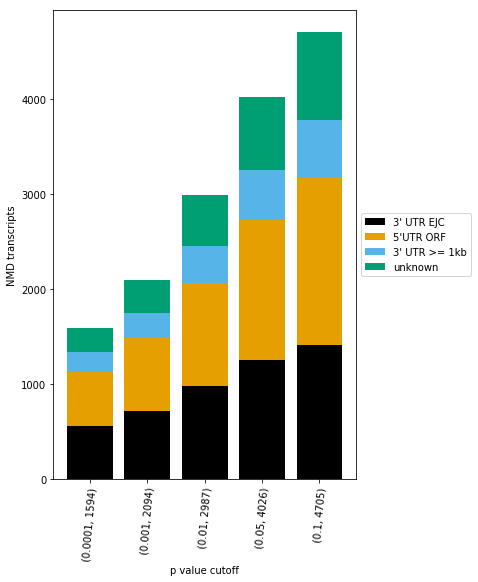

In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines

ind = numpy.arange(len(p_values))  # the x locations for the groups
width = 0.8  # the width of the bars: can also be len(x) sequence
plotLayers = []
bottoms = [0] * len(p_values)
bottoms = numpy.array(bottoms)

anno_names = ['3\' UTR EJC', '5\'UTR ORF', '3\' UTR >= 1kb', 'unknown']
anno_counts = [nmd_EJC_counts, nmd_uORF_counts, nmd_longUTR_counts, other_counts]

fig = plt.figure(figsize=(8, 8))
num_plots_wide = 1
num_plots_high = 1
plot = fig.add_subplot(num_plots_high, num_plots_wide, 1)

color_index = 0
for index in range(len(anno_names)):
    values = numpy.array(anno_counts[index]).astype(float)
    plotLayers.append(plot.bar(ind, values, width, bottom=bottoms,
                                   color=colors[color_index % len(colors)],
                                   label=anno_names[index]))
    bottoms = bottoms + values
    color_index+=1

plt.ylabel('NMD transcripts')
plot.set_xticks(ind)
plot.set_xticklabels(zip(p_values,nmd_counts), rotation=85)
plt.tight_layout()
# Shrink current axis by 40%
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# Put a legend to the right of the current axis
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plot.set_ylim(0, 100)
plot.set_xlabel('p value cutoff')
# plt.subplots_adjust(bottom=0.38, right=0.8)
plt.savefig('20191026_anno_counts.pdf', transparent=True)

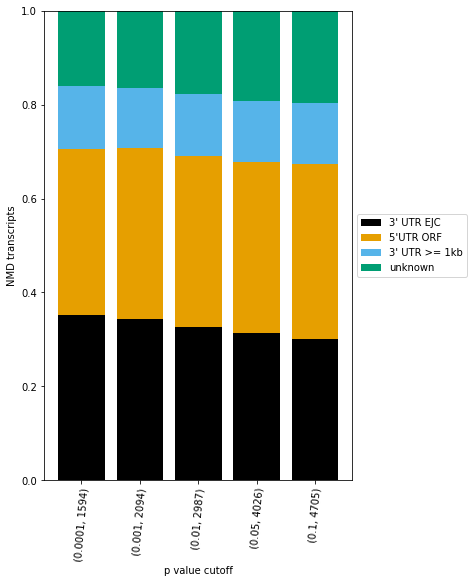

In [13]:
import numpy
ind = numpy.arange(len(p_values))  # the x locations for the groups
width = 0.8  # the width of the bars: can also be len(x) sequence
plotLayers = []
bottoms = [0] * len(p_values)
bottoms = numpy.array(bottoms)

anno_names = ['3\' UTR EJC', '5\'UTR ORF', '3\' UTR >= 1kb', 'unknown']
anno_counts = [nmd_EJC_counts, nmd_uORF_counts, nmd_longUTR_counts, other_counts]

fig = plt.figure(figsize=(8, 8))
num_plots_wide = 1
num_plots_high = 1
plot = fig.add_subplot(num_plots_high, num_plots_wide, 1)

color_index = 0
for index in range(len(anno_names)):
    values = numpy.array(anno_counts[index]).astype(float)/numpy.array(nmd_counts).astype(float)
    plotLayers.append(plot.bar(ind, values, width, bottom=bottoms,
                                   color=colors[color_index % len(colors)],
                                   label=anno_names[index]))
    bottoms = bottoms + values
    color_index+=1

plt.ylabel('NMD transcripts')
plot.set_xticks(ind)
plot.set_xticklabels(zip(p_values,nmd_counts), rotation=85)
plt.tight_layout()
# Shrink current axis by 40%
box = plot.get_position()
plot.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# Put a legend to the right of the current axis
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot.set_ylim(0, 1)
plot.set_xlabel('p value cutoff')
# plt.subplots_adjust(bottom=0.38, right=0.8)
plt.savefig('20191026_anno_counts_nmd_normed.pdf', transparent=True)

Import and combine Xtail analysis results

In [14]:
#import and concatenate data
import pandas as pd
import numpy as np
import math
columns = ['transcript','mRNA_log2FC','RPF_log2FC','log2FC_TE_v1','pvalue_v1','nontargeting_log2TE','perturbation_log2TE','log2FC_TE_v2','pvalue_v2','log2FC_TE_final','pvalue_final','pvalue.adjust','dataset']
smg1i_xtail_results = pd.read_csv('20191117_salmon_xtail/20191117_xtail_SMG1i_mono_RNA.tsv', sep='\t')
smg1i_xtail_results['dataset'] = 'SMG1i'
smg1i_xtail_results.columns = columns
gigyf2_xtail_results = pd.read_csv('20191117_salmon_xtail/20191117_xtail_GIGYF2_mono_RNA.tsv', sep='\t')
gigyf2_xtail_results['dataset'] = 'GIGYF2'
gigyf2_xtail_results.columns = columns
eif4e2_xtail_results = pd.read_csv('20191117_salmon_xtail/20191117_xtail_eIF4E2_mono_RNA.tsv', sep='\t')
eif4e2_xtail_results['dataset'] = 'eIF4E2'
eif4e2_xtail_results.columns = columns

combined_xtail_results = pd.concat([smg1i_xtail_results, gigyf2_xtail_results, eif4e2_xtail_results], sort=False)

def extract_gene_id(x):
    info_parts = x.split('|')
    return info_parts[1]

def extract_gene_name(x):
    info_parts = x.split('|')
    if info_parts[0] == 'UGAC_reporter':
        return info_parts[0]
    else:
        return info_parts[5]

def extract_tx_id(x):
    info_parts = x.split('|')
    return info_parts[0]

combined_xtail_results['gene_id'] = combined_xtail_results['transcript'].apply(extract_gene_id)
combined_xtail_results['gene_name'] = combined_xtail_results['transcript'].apply(extract_gene_name)
combined_xtail_results['tx_id'] = combined_xtail_results['transcript'].apply(extract_tx_id)

Plot mRNA and monosome fold changes

## Repeat this analysis, making sure the same set of mRNAs are used in each line

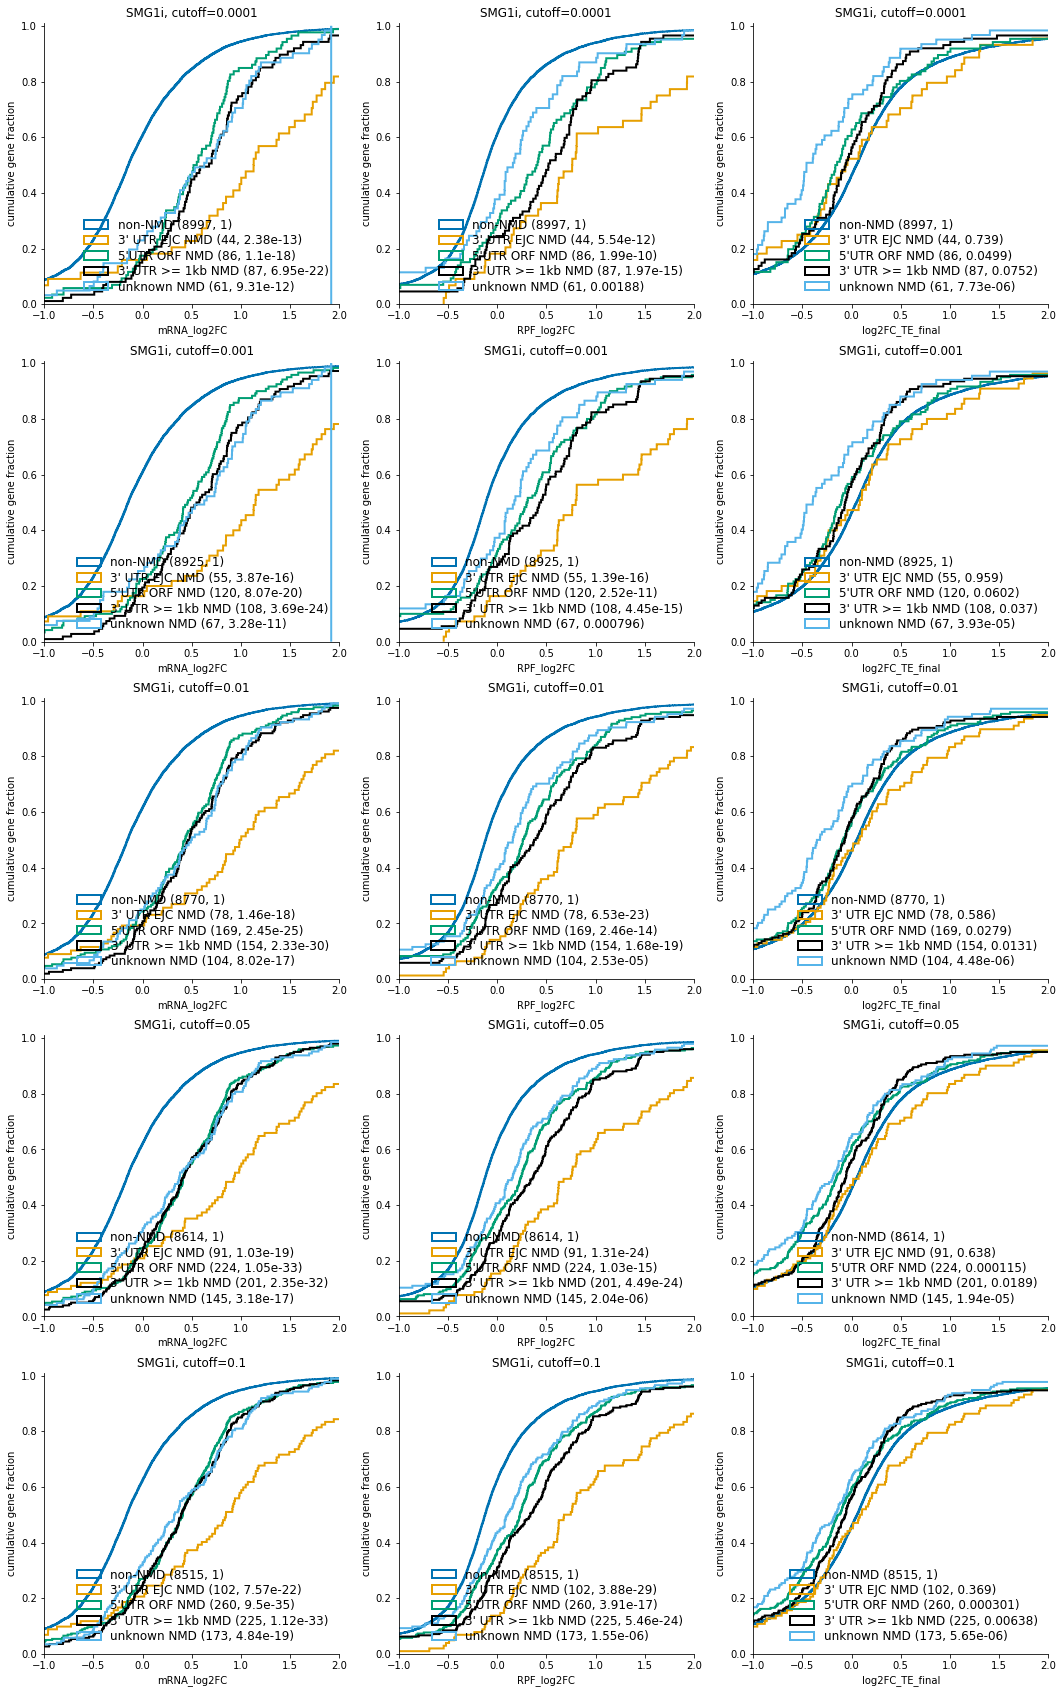

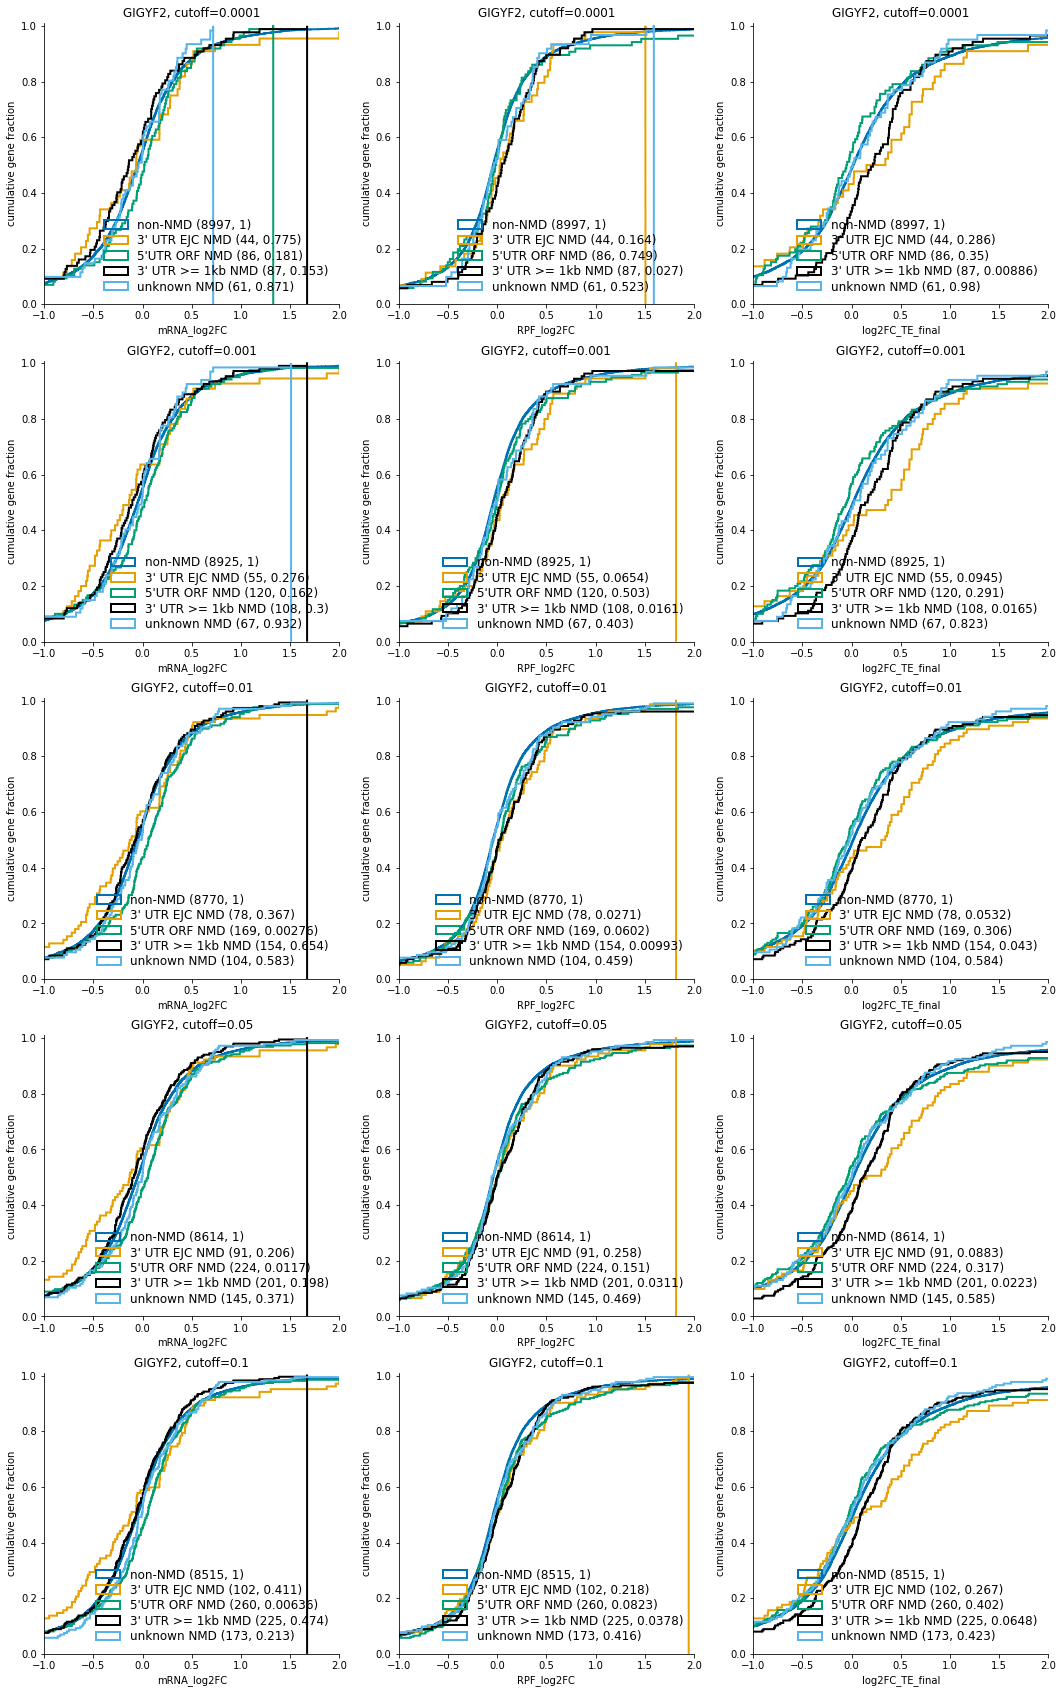

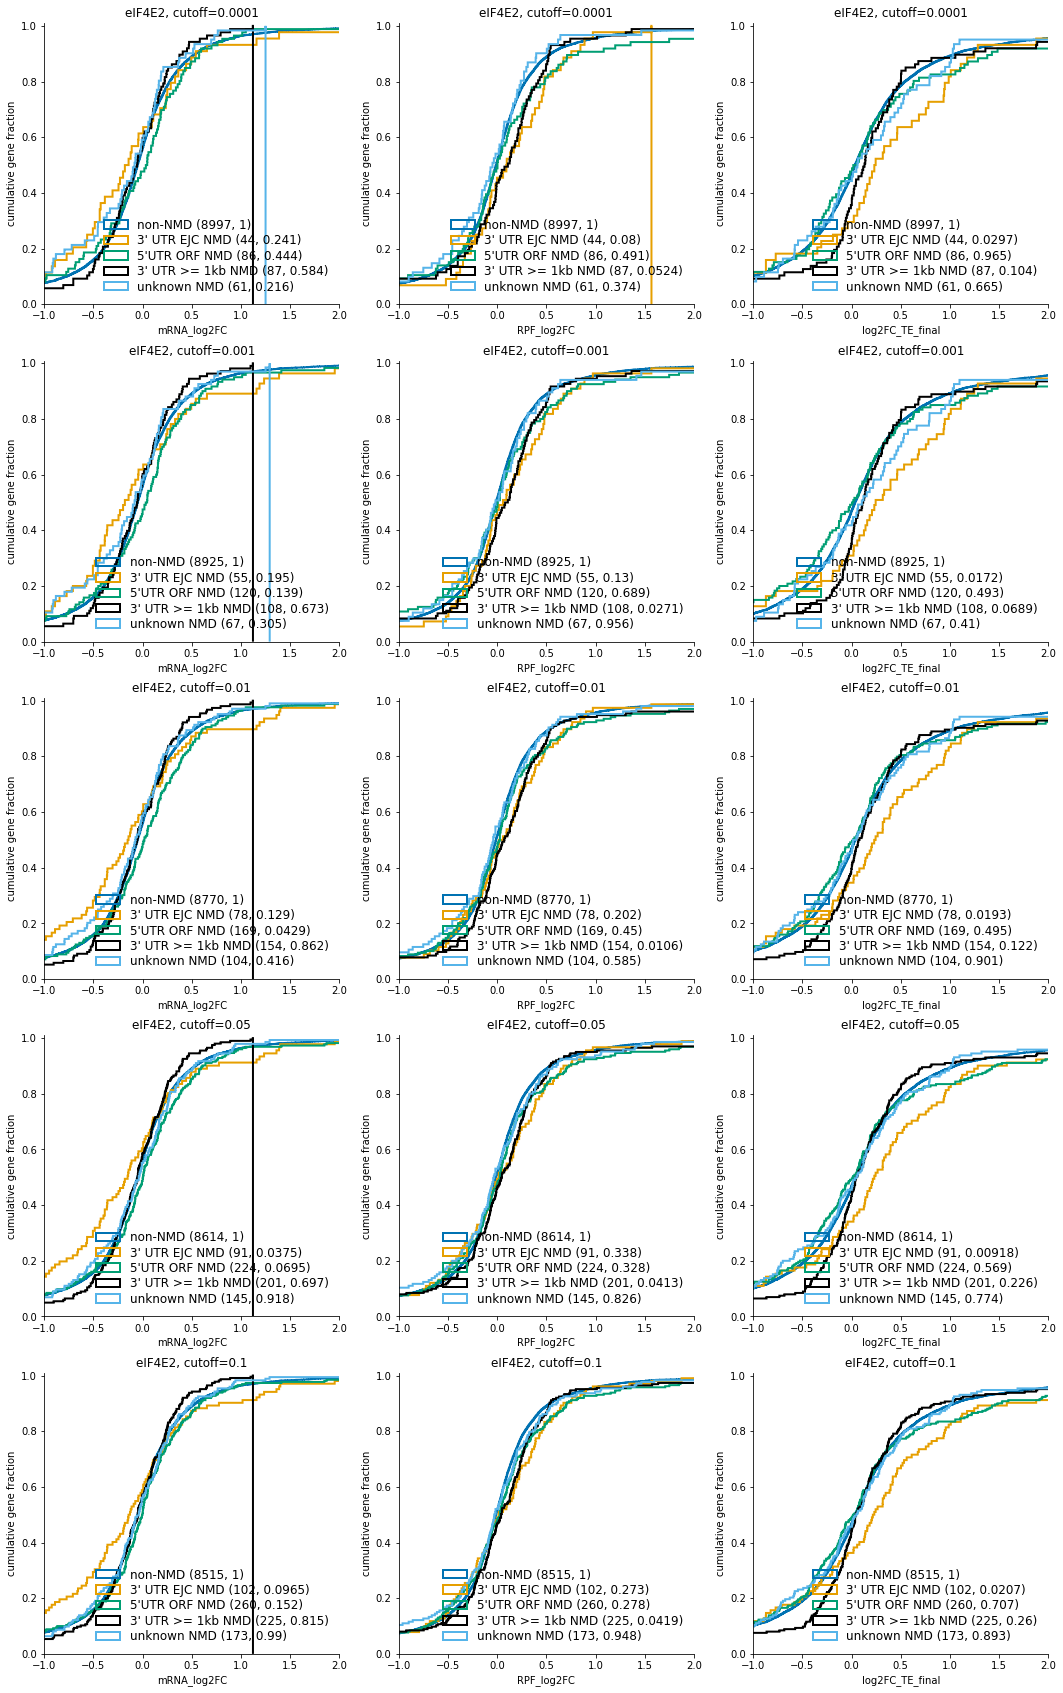

In [15]:
#plot fold changes
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
##plot CDF or mRNA RPKMs
black = (0,0,0)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [blue, orange, bluishGreen, black, skyBlue, vermillion, reddishPurple, yellow]
rainbow = [black, vermillion, orange, bluishGreen, blue, reddishPurple, 'violet']

variables_to_plot = ['mRNA_log2FC', 'RPF_log2FC', 'log2FC_TE_final']
p_values = [.0001, .001, .01,.05, .1]

dataset = combined_xtail_results['dataset'].unique()[0]
group_xtail = combined_xtail_results.groupby('dataset')
df = group_xtail.get_group(dataset)
tx_overlap = set(df.dropna()['tx_id'])
for dataset in combined_xtail_results['dataset'].unique():
    df = group_xtail.get_group(dataset)
    tx_overlap = tx_overlap.intersection(set(df.dropna()['tx_id']))

    
for dataset in combined_xtail_results['dataset'].unique():
    plot_index = 1
    num_plots_wide = len(variables_to_plot)
    num_plots_high = len(p_values)

    fig = plt.figure(figsize=(6*num_plots_wide, 6*num_plots_high))
    df = group_xtail.get_group(dataset)
    df = df[df['tx_id'].isin(tx_overlap)]
    for p in p_values:
        all_NMD_targets = colombo_p_values[colombo_p_values['meta_meta']<p]
        NMD_EJC = all_NMD_targets[all_NMD_targets['has dEJC']]
        NMD_noEJC = all_NMD_targets[~all_NMD_targets['has dEJC']]
        NMD_uORF = NMD_noEJC[NMD_noEJC['has_uORF']]
        NMD_nouORF = NMD_noEJC[~NMD_noEJC['has_uORF']]
        NMD_longUTR = NMD_nouORF[NMD_nouORF['3UTR length']>999]
        NMD_nolongUTR = NMD_nouORF[~(NMD_nouORF['3UTR length']>999)]
        for variable_to_plot in variables_to_plot:
            plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
            color_index = 0
            nmd_df = df[df['tx_id'].isin(all_NMD_targets['tx_id'])]
            no_nmd_df = df[~df['tx_id'].isin(all_NMD_targets['tx_id'])]
            nmd_ejc_df = df[df['tx_id'].isin(NMD_EJC['tx_id'])]
            nmd_uORF_df = df[df['tx_id'].isin(NMD_uORF['tx_id'])]
            nmd_longUTR_df = df[df['tx_id'].isin(NMD_longUTR['tx_id'])]
            nmd_other_df = df[df['tx_id'].isin(NMD_nolongUTR['tx_id'])]
            
            filtered_data = [no_nmd_df, nmd_ejc_df, nmd_uORF_df, nmd_longUTR_df, nmd_other_df]
            group_names = ['non-NMD', '3\' UTR EJC NMD', '5\'UTR ORF NMD', '3\' UTR >= 1kb NMD', 'unknown NMD']
            for index in range(len(filtered_data)):
                mwu, mwp = stats.mannwhitneyu(no_nmd_df[variable_to_plot], filtered_data[index][variable_to_plot], alternative='two-sided')
                plot.hist(filtered_data[index][variable_to_plot], 10000, density=1, cumulative=True, histtype='step', color=colors[color_index], label='%s (%d, %.3g)' %(group_names[index], len(filtered_data[index][variable_to_plot]), mwp), lw=2)
                color_index+=1
            plot.set_xlabel(variable_to_plot)
            plot.set_ylabel("cumulative gene fraction")
            plot.set_title('%s, cutoff=%.3g' % (dataset, p))
            plot.set_ylim(0, 1.01)
            #if variable_to_plot == 'log2FC_TE_final':
            #    plot.set_xlim(-1, 1)
            #else:
            plot.set_xlim(-1, 2)
            plot.spines['right'].set_visible(False)
            plot.spines['top'].set_visible(False)
            plot_index += 1
            lg=plt.legend(loc=4,prop={'size':12}, labelspacing=0.2)
            lg.draw_frame(False)
    #plt.tight_layout()
    plt.savefig('E5.044_20191117_CDF_%s.pdf' % (dataset), transparent='True', format='pdf')